# Inequality conditions

To get to this stage of the notebooks, you will have encountered examples of how boolean logic can be implemented in a quantum circuit through controlled operations and NOT gates, and likely have a good grasp of how to perform AND, NAND, OR and XOR operations on a quantum computer (if not, this would be a good point to familiarize yourself with these operations as an exercise). 

Here we will look into how to condition an operation $\hat{U}$ based upon inequalities given some input $x$ and inequality $x\le a$ or $x\ge a$. 

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Let us define our $x$ and $a$. First, let's consider integer values:

In [2]:
digit = 2
a = 1

and consider the minimum number of quibits:

In [3]:
phase = False

nint = qt.get_nint([digit,a])
npres = qt.get_npres([digit,a])
n = nint + npres

if phase:
    n+=1

print(n, nint, npres)

2 2 0


In [4]:
binary_x = qt.my_binary_repr(digit, n, nint=nint, phase=phase)
binary_a = qt.my_binary_repr(a, n, nint=nint, phase=phase)

These values are stored in binary as:

In [5]:
print(binary_x,binary_a)

10 01


First, we are considering the condition $x\ge a$:

In [6]:
print('It is',digit>=a,'that',str(digit)+' >= '+str(a)+'.')

It is True that 2 >= 1.


We begin by initialising an $x$ register of $n$ qubit, an ancillary register of $n-1$ qubits and a target qubit:

In [7]:
qx = QuantumRegister(n, 'x')
qtarg = QuantumRegister(1, 'targ')
qans = QuantumRegister(n-1, 'anc')
out_reg = ClassicalRegister(1,'out_reg')
circ = QuantumCircuit(qx, qtarg, qans, out_reg)

Let us input the binary representation of $x$ into the register:

In [8]:
x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

We can use the function `integer_compare` to compare the value stored in $x$ to an input value $a$, with $x\ge a$ by setting `geq=True`:

In [9]:
intcomp_gate = qt.integer_compare(circ, qx, qtarg, qans, a, geq=True, wrap=True)
circ.append(intcomp_gate, [*qx, *qtarg, *qans]);

The result will be stored in the target qubit as a boolean value, which we can measure:

In [10]:
circ.measure(qtarg, out_reg);

The circuit can be visualised as:

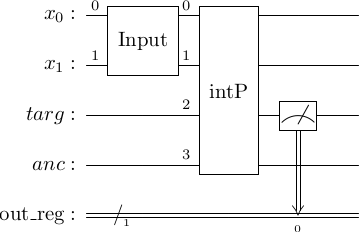

In [11]:
circ.draw('latex')

Or on a closer inspection, we can decompose the circuit into smaller components:

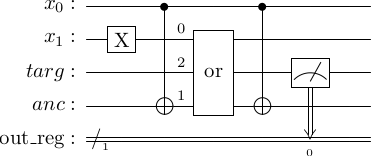

In [12]:
circ.decompose(reps=1).draw('latex')

We can see that the inequality condition is enforced by a series of boolean logic operations.

In [13]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

By simulating this circuit and sampling measurements of the target qubit, we get the result:

In [14]:
print('Target:')
print(digit,'>=',a,'=',digit>=a)

print('Result:')
for label in hist.keys():
    print(digit,'>=',a,'=',bool(qt.bin_to_dec(label, nint=nint, phase=False)),'->',label,'with probability',float(hist[label])/shots)

Target:
2 >= 1 = True
Result:
2 >= 1 = True -> 1 with probability 1.0


We can see that the condition is successfully evaluated. Now let's make this comparison between values with fractional parts:

In [15]:
digit = 1.5
a = 2.25

phase = False

nint = qt.get_nint([digit,a])
npres = qt.get_npres([digit,a])
n = nint + npres

if phase:
    n+=1

print(n, nint, npres)

binary_x = qt.my_binary_repr(digit, n, nint=nint, phase=phase)
binary_a = qt.my_binary_repr(a, n, nint=nint, phase=phase)

4 2 2


We can find integers that correspond to these binary strings: 

In [16]:
int_x = qt.bin_to_dec(binary_x, nint=None, phase=False)
int_a = qt.bin_to_dec(binary_a, nint=None, phase=False)

This transformation works as:

In [17]:
print(digit,'->',binary_x,'->',int(int_x),',',a,'->',binary_a,'->',int(int_a))

1.5 -> 0110 -> 6 , 2.25 -> 1001 -> 9


We can see that the integer versions follow the same outcomes to the condition:

In [18]:
print('It is',digit>=a,'that',str(digit)+' >= '+str(a)+', and it is',int_x>=int_a,'that',str(int_x)+' >= '+str(int_a))

It is False that 1.5 >= 2.25, and it is False that 6.0 >= 9.0


Again, we initialise the registers:

In [19]:
qx = QuantumRegister(n, 'x')
qtarg = QuantumRegister(1, 'targ')
qans = QuantumRegister(n-1, 'anc')
out_reg = ClassicalRegister(1,'out_reg')
circ = QuantumCircuit(qx, qtarg, qans, out_reg)

and input the $x$ binary string: 

In [20]:
x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

We can use the `integer_compare` function again with the intger version of $a$ given as an input:

In [21]:
intcomp_gate = qt.integer_compare(circ, qx, qtarg, qans, int_a, geq=True, wrap=True)
circ.append(intcomp_gate, [*qx, *qtarg, *qans]);

Again the outcome of measuring the target qubit results in the outcome:

In [22]:
circ.measure(qtarg, out_reg);

In [23]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [24]:
print('Target:')
print(digit,'>=',a,'=',digit>=a)

print('Result:')
for label in hist.keys():
    print(digit,'>=',a,'=',bool(qt.bin_to_dec(label, nint=nint, phase=False)),'->',label,'with probability',float(hist[label])/shots)

Target:
1.5 >= 2.25 = False
Result:
1.5 >= 2.25 = False -> 0 with probability 1.0


Correct again!

Let us now expand this further to also include negative value comparisons. Let us consider twos-complement representation to do this:

In [25]:
digit = -1.5
a = 2.25

phase = True

nint = qt.get_nint([digit,a])
npres = qt.get_npres([digit,a])
n = nint + npres

if phase:
    n+=1

print(n, nint, npres)

binary_x = qt.my_binary_repr(digit, n, nint=nint, phase=phase)
binary_a = qt.my_binary_repr(a, n, nint=nint, phase=phase)

5 2 2


Again, we can use the `integer_compare` tool by converting to an integer representation of $a$. However, we must also flip the leading order bit (the phase bit) of the binary string. This is equivalent to adding $2^{n_{int+1}}$ to either side of the inequality, and therefore will not break the condition. 

Let us do this for the $a$ binary string:

In [26]:
binary_a_ = qt.my_binary_repr(a, n, nint=nint, phase=phase)

if binary_a[0]=='0':
    binary_a_ = '1'+binary_a[1:]
elif binary_a[0]=='1':
    binary_a_ = '0'+binary_a[1:]

as well as the $x$ binary string for comparison:

In [27]:
binary_x_ = qt.my_binary_repr(digit, n, nint=nint, phase=phase)

if binary_x[0]=='0':
    binary_x_ = '1'+binary_x[1:]
elif binary_x[0]=='1':
    binary_x_ = '0'+binary_x[1:]

Now converting these values to integers gives:

In [28]:
int_x = qt.bin_to_dec(binary_x_, nint=None, phase=False)
int_a = qt.bin_to_dec(binary_a_, nint=None, phase=False)

The full transformation resembles:

In [29]:
print(digit,'->',binary_x,'->',binary_x_,'->',int(int_x),',',a,'->',binary_a,'->',binary_a_,'->',int(int_a))

-1.5 -> 11010 -> 01010 -> 10 , 2.25 -> 01001 -> 11001 -> 25


and we can see this leaves the condition unchanged:

In [30]:
print('It is',digit>=a,'that',str(digit)+' >= '+str(a)+', and it is',int_x>=int_a,'that',str(int_x)+' >= '+str(int_a))

It is False that -1.5 >= 2.25, and it is False that 10.0 >= 25.0


Let's run this in our quantum circuit:

In [31]:
qx = QuantumRegister(n, 'x')
qtarg = QuantumRegister(1, 'targ')
qans = QuantumRegister(n-1, 'anc')
out_reg = ClassicalRegister(1,'out_reg')
circ = QuantumCircuit(qx, qtarg, qans, out_reg)

We can directly load the $x$ binary string:

In [32]:
x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

then perform the $2^{n_{int}+1}$ addition by bit flipping the phase qubit:

In [33]:
circ.x(qx[-1]);

As before, we can perform the integer comparison and give the `integer_compare` function the interger version of $a$:

In [34]:
intcomp_gate = qt.integer_compare(circ, qx, qtarg, qans, int_a, geq=True, wrap=True)
circ.append(intcomp_gate, [*qx, *qtarg, *qans]);

Reverting back to the original $x$ value can now be done with another $X$ gate:

In [35]:
circ.x(qx[-1]);

In [36]:
circ.measure(qtarg, out_reg);

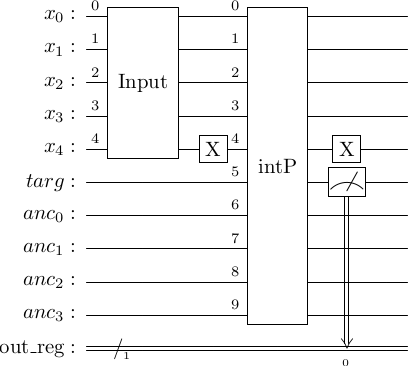

In [37]:
circ.draw('latex')

Simulating the measurement results in:

In [38]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [39]:
print('Target:')
print(digit,'>=',a,'=',digit>=a)

print('Result:')
for label in hist.keys():
    print(digit,'>=',a,'=',bool(qt.bin_to_dec(label, nint=nint, phase=False)),'->',label,'with probability',float(hist[label])/shots)

Target:
-1.5 >= 2.25 = False
Result:
-1.5 >= 2.25 = False -> 0 with probability 1.0


as desired!

Now that this seems to work generally let us demonstrate the same case but for $x\le a$:

In [40]:
digit = -1.5
a = 2.25

phase = True

nint = qt.get_nint([digit,a])
npres = qt.get_npres([digit,a])
n = nint + npres

if phase:
    n+=1
    
binary_x = qt.my_binary_repr(digit, n, nint=nint, phase=phase)
binary_a = qt.my_binary_repr(a, n, nint=nint, phase=phase)

binary_x_ = qt.my_binary_repr(digit, n, nint=nint, phase=phase)

if binary_x[0]=='0':
    binary_x_ = '1'+binary_x[1:]
elif binary_x[0]=='1':
    binary_x_ = '0'+binary_x[1:]
    
binary_a_ = qt.my_binary_repr(a, n, nint=nint, phase=phase)

if binary_a[0]=='0':
    binary_a_ = '1'+binary_a[1:]
elif binary_a[0]=='1':
    binary_a_ = '0'+binary_a[1:]
    
int_x = qt.bin_to_dec(binary_x_, nint=None, phase=False)
int_a = qt.bin_to_dec(binary_a_, nint=None, phase=False)

The same circuit can be constructed, but with the option `geq=False` set in the `integer_compare` function:

In [41]:
qx = QuantumRegister(n, 'x')
qtarg = QuantumRegister(1, 'targ')
qans = QuantumRegister(n-1, 'anc')
out_reg = ClassicalRegister(1,'out_reg')
circ = QuantumCircuit(qx, qtarg, qans, out_reg)

x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

circ.x(qx[-1]);
intcomp_gate = qt.integer_compare(circ, qx, qtarg, qans, int_a, geq=False, wrap=True)
circ.append(intcomp_gate, [*qx, *qtarg, *qans]);
circ.x(qx[-1]);

circ.measure(qtarg, out_reg);

In [42]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [43]:
print('Target:')
print(digit,'<=',a,'=',digit<=a)

print('Result:')
for label in hist.keys():
    print(digit,'<=',a,'=',bool(qt.bin_to_dec(label, nint=nint, phase=False)),'->',label,'with probability',float(hist[label])/shots)

Target:
-1.5 <= 2.25 = True
Result:
-1.5 <= 2.25 = True -> 1 with probability 1.0


Giving the correct result! After all that, lets just wrap all of this into a single function `inequal_cond` which will handle the phase and fractional parts of numbers as described in this notebook.

In [44]:
digit = 3.5
a = 2.25

phase = True

nint = qt.get_nint([digit,a])
npres = qt.get_npres([digit,a])
n = nint + npres

if phase:
    n+=1
    
binary_x = qt.my_binary_repr(digit, n, nint=nint, phase=phase)

In [45]:
qx = QuantumRegister(n, 'x')
qtarg = QuantumRegister(1, 'targ')
qans = QuantumRegister(n-1, 'anc')
out_reg = ClassicalRegister(1,'out_reg')
circ = QuantumCircuit(qx, qtarg, qans, out_reg)

x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

comp_gate = qt.inequal_cond(circ, qx, qtarg, qans, a, nint=nint, phase=phase, geq=False, wrap=True)
circ.append(comp_gate, [*qx, *qtarg, *qans]);

circ.measure(qtarg, out_reg);

In [46]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [47]:
print('Target:')
print(digit,'<=',a,'=',digit<=a)

print('Result:')
for label in hist.keys():
    print(digit,'<=',a,'=',bool(qt.bin_to_dec(label, nint=nint, phase=False)),'->',label,'with probability',float(hist[label])/shots)

Target:
3.5 <= 2.25 = False
Result:
3.5 <= 2.25 = False -> 0 with probability 1.0


You may be thinking, this is just like the previous notebook with multiplication - why did we go through all those examples when these problems are dealt with inside the `qiskit_tools` functions internally. Well, similarly to the multiplication case, this notebook looks to demonstrate how the binary representation matters and how inputs are treated differently depending on if they are in the phase-magnitude or the twos-complement representation. Here, we demonstrate how the inequalities can be straightforwardly handled when considering twos-complement representation. However, this may not be so straightforward for sign-magnitude representation. We use the fact that every binary string in twos-complement notation can be mapped to an integer. This is not the case with sign-magnitude (with both positive and negative zero)!

### Task

Can you generalise the `inequal_cond` function to handle sign-magnitude as well as twos-complement representation? This may require editing the `integer_compare` function as well.